In [1]:
import torch
import torchvision.models as models

model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()


from PIL import Image
from torchvision import transforms
from sklearn.metrics.pairwise import cosine_similarity

# image_path = 'data/DAM/010M03A1116X9000.jpeg'
# input_image = Image.open(image_path)

image_paths = [
	'data/DAM/012B03A3985X5902.jpeg',
	'data/DAM/012A09A3232X5597.jpeg',
	'data/DAM/14DDN978A133C568.jpeg'
]


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Extract features for each image
features_list = []
for image_path in image_paths:
    input_image = Image.open(image_path)
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        features = model(input_batch)

    # Convert features to a numpy array and flatten it
    features_list.append(features.cpu().numpy().flatten())

# Compute cosine similarity between features
cosine_similarities = cosine_similarity(features_list)

# Print the cosine similarity matrix
print("Cosine Similarity Matrix:")
print(cosine_similarities)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Cosine Similarity Matrix:
[[1.         0.7414424  0.6193912 ]
 [0.7414424  1.         0.67094374]
 [0.6193912  0.67094374 0.9999997 ]]


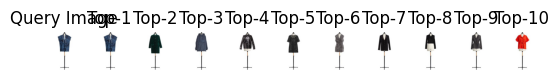

In [5]:
from PIL import Image
from torchvision import transforms
from sklearn.metrics.pairwise import cosine_similarity
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# Path to the DAM image for comparison
query_image_path = 'data/DAM/012B03A3985X5902.jpeg'

# Path to the data folder
data_folder = 'data'

# Number of top similar images to retrieve
top_k = 10

# Load and preprocess the query image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

query_image = Image.open(query_image_path)
query_tensor = preprocess(query_image)
query_batch = query_tensor.unsqueeze(0)  # Add batch dimension

with torch.no_grad():
    query_features = model(query_batch)

# Function to calculate cosine similarity between two feature vectors
def calculate_cosine_similarity(feature1, feature2):
    # Ensure the features are 1D tensors
    feature1 = feature1.flatten()
    feature2 = feature2.flatten()

    # Convert tensors to numpy arrays
    feature1_np = feature1.cpu().numpy()
    feature2_np = feature2.cpu().numpy()

    # Calculate cosine similarity
    similarity = cosine_similarity([feature1_np], [feature2_np])[0, 0]

    return similarity

# Calculate cosine similarity with all other images in the DAM folder
similarities = []
image_paths = []

dam_folder = os.path.join(data_folder, 'DAM')

for filename in os.listdir(dam_folder):
    if filename.endswith('.jpeg'):
        image_path = os.path.join(dam_folder, filename)
        image_paths.append(image_path)

        # Load and preprocess the image
        input_image = Image.open(image_path)
        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            features = model(input_batch)

        # Calculate cosine similarity with the query image
        similarity = calculate_cosine_similarity(query_features, features)
        similarities.append(similarity)

# Get indices of top-k similar images
top_indices = np.argsort(similarities)[-top_k:][::-1]

# Display the query image
plt.subplot(1, top_k + 1, 1)
plt.imshow(query_image)
plt.title('Query Image')
plt.axis('off')

# Display the top-k similar images
for i, index in enumerate(top_indices):
    image_path = image_paths[index]
    similar_image = Image.open(image_path)

    plt.subplot(1, top_k + 1, i + 2)
    plt.imshow(similar_image)
    plt.title(f'Top-{i + 1}')
    plt.axis('off')

plt.show()